In [1]:
## This Notebook offers an important note about test_mf_plotter()	
# Although test_mf_plotter() does not work with 'pytest ligotools'- because it runs into a, really confusing, TclError.
# Nevertheless! As seen in this demo.ipynb, test_mf_plotter() works correctly in the noteboook format.

In [2]:
from ligotools.utils import whiten, write_wavfile, reqshift, mf_plotter

import json
from ligotools.readligo import loaddata
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import wave
import contextlib
from os.path import exists
from os import remove
import numpy as np
from scipy.signal import butter, filtfilt
import h5py
from scipy import signal

/home/jovyan/envs/ligo/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/jovyan/envs/ligo/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


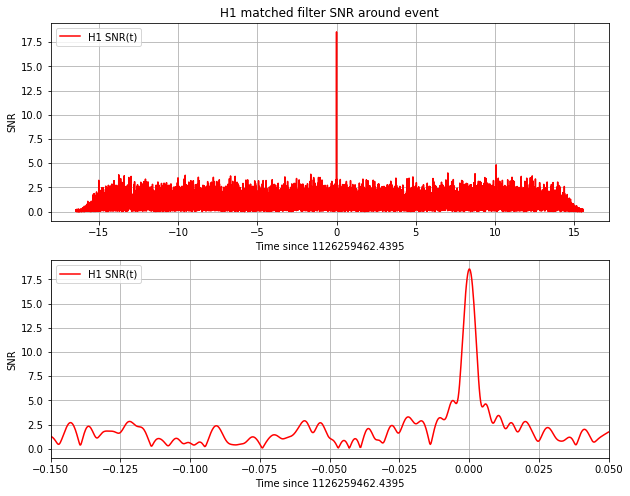

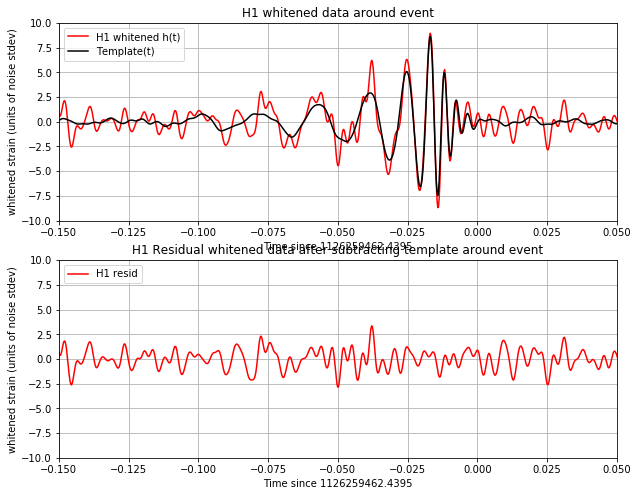

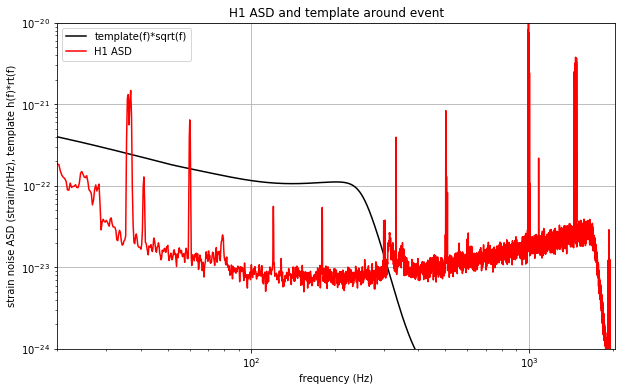

In [3]:
#def test_mf_plotter(): 
eventname = 'GW150914'
fnjson = "data/BBH_events_v3.json"
events = json.load(open(fnjson,"r"))
event = events[eventname]
fn_H1 = "data/"+event['fn_H1']
strain_H1, time_H1, chan_dict_H1 = loaddata(fn_H1, 'H1')

fn_template = "data/"+event['fn_template']
fs = event['fs']                   
tevent = event['tevent']            
fband = event['fband'] 

time = time_H1
dt = time[1] - time[0]

NFFT = 4*fs
Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
psd_window = np.blackman(NFFT)
psd_H1 = interp1d(freqs, Pxx_H1)

strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization

f_template = h5py.File(fn_template, "r")
template_p, template_c = f_template["template"][...]

NOVL = NFFT/2
template = (template_p + template_c*1.j) 
#etime = time+template_offset
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])
dwindow = signal.tukey(template.size, alpha=1./8)
template_fft = np.fft.fft(template*dwindow) / fs

det = "H1"
data = strain_H1.copy()
data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
data_fft = np.fft.fft(data*dwindow) / fs
power_vec = np.interp(np.abs(datafreq), freqs, data_psd)
optimal = data_fft * template_fft.conjugate() / power_vec
optimal_time = 2*np.fft.ifft(optimal)*fs
sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR_complex = optimal_time/sigma
peaksample = int(data.size / 2)  # location of peak in the template
SNR_complex = np.roll(SNR_complex,peaksample)
SNR = abs(SNR_complex)
indmax = np.argmax(SNR)
timemax = time[indmax]
SNRmax = SNR[indmax]
d_eff = sigma / SNRmax
horizon = sigma/8
phase = np.angle(SNR_complex[indmax])
offset = (indmax-peaksample)
template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude
template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template

plottype = "png"
pcolor='r'
strain_whitenbp = strain_H1_whitenbp
template_H1 = template_match.copy()

mf_plotter(time,
           timemax,
           SNR,
           pcolor,
           det,
           eventname,
           plottype,
           tevent,
           strain_whitenbp,
           template_match,
           template_fft,
           datafreq,
           d_eff,
           freqs,
           data_psd,
           fs
          )
H1SNR = "figures/GW150914_H1_SNR.png"
H1WHITE = "figures/GW150914_H1_matchtime.png"
H1ASD = "figures/GW150914_H1_matchfreq.png"
assert (exists(H1SNR)) & (exists(H1WHITE)) & (exists(H1ASD)), "the plotting utility- called mf_plotter()- is not creating at least one of the three desired plot image types"
remove(H1SNR)
remove(H1WHITE)
remove(H1ASD)